In [316]:
import itertools as it
from math import comb
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.optimize import minimize
from tqdm.notebook import tqdm

### 1) Initialize Parameters

In [418]:
D_r = 300 # number of reservoir nodes
T = 100 # s, duration of time series
dt = 0.02 # s, time step

num_steps = int(T/dt)

d = 6 # average degree of Erdos-Renyi network
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0 # regularization parameter

sigma = 0.1 # standard deviation of the input weights

D = 3 # dimension of input u

### 2) Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\rho = 28$, $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [419]:
# dt, T are in milliseconds
def simulate_lorenz(rho=28, beta=8/3, sigma=10, dt=0.01, T = 50, initial_condition=None):
    if initial_condition is None:
        initial_condition = np.random.normal(size=(3,))
    
    time_vals = np.arange(0, T, dt)
    pts = np.zeros((len(time_vals), 3))
    pts[0] = initial_condition
    
    for t in range(1, len(time_vals)):
        x, y, z = pts[t - 1]
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        
        x += dx*dt
        y += dy*dt
        z += dz*dt
        
        pts[t] = [x, y, z]
    
    return pts, time_vals

In [420]:
lorenz_pts, time_vals = simulate_lorenz(dt=dt, T=T)

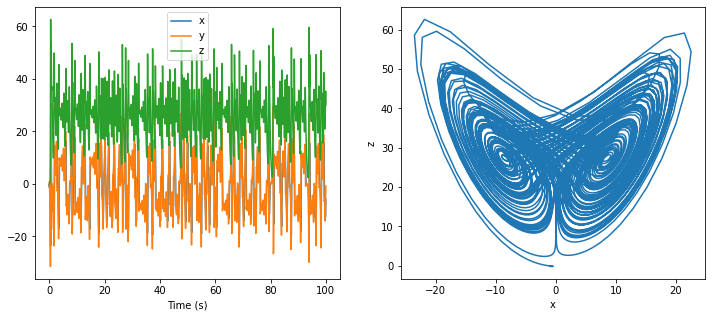

In [421]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

### 3) Set up the adjacency matrix

The paper says: "The reservoir network is built from a sparse random Erdos-Rényi network whose average degree is $d= 6$. Each non-zero element in the adjacency matrix is drawn independently and uniformly from $[−a, a]$, and $a >0$ is adjusted so that the spectral radius of $\mathbf{A}$ (the largest magnitude of its eigenvalues) has a desired value $\rho$."

The `networkx` function to make this graph only has the probability $p$ of creating an edge as a parameter, so let's see if we can pick $p$ so that $\mathbb{E}[\frac{2\lvert E \rvert}{D_r}] = d$ where $2\lvert E \rvert$ is the sum of the degrees (since $\sum_{v \in V} \deg(v) = 2\lvert E \rvert$) , $D_r$ is the number of nodes in the reservoir network, and $d$ is the desired average degree.

Since for an Erdos-Renyi graph $\mathbb{E}[\lvert E \rvert] = {D_r \choose 2}p$, $\mathbb{E}[\frac{2\lvert E \rvert}{D_r}] = \frac{2{D_r \choose 2}p}{D_r}$ and so we can choose $p = \frac{dD_r}{2{D_r \choose 2}}$.

In [422]:
p = d*D_r/(2*comb(D_r, 2))
adjacency_graph = nx.erdos_renyi_graph(D_r, p)
avg_degree = np.sum([adjacency_graph.degree[i] for i in range(D_r)])/D_r
print(f"The average degree of the network is {avg_degree:.2f}")

The average degree of the network is 6.03


In [423]:
def fill_adjacency_matrix_weights(A_binary, a):
    A = np.zeros(A_binary.shape)
    for i, j in it.product(range(D_r), range(D_r)):
        if A_binary[i, j]:     
            A[i, j] = np.random.uniform(low=-a, high=a)
    return A

A_binary = nx.linalg.graphmatrix.adj_matrix(adjacency_graph).toarray()

a_vals = np.linspace(0, 2, 1001) 
spectral_radius = np.zeros(len(a_vals))
A_mats = np.zeros((len(a_vals), D_r, D_r))
for i, a in tqdm(enumerate(a_vals), total=len(a_vals)):
    A_mats[i] = fill_adjacency_matrix_weights(A_binary, a)
    eigenvalues, _ = np.linalg.eig(A_mats[i])
    spectral_radius[i] = np.abs(eigenvalues).max()

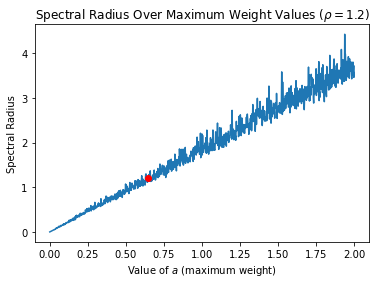

In [424]:
opt_ind = np.argmin(np.abs(spectral_radius - rho))
a = a_vals[opt_ind]
A = A_mats[opt_ind]
plt.scatter(a, spectral_radius[opt_ind], c='red', zorder=2)
plt.plot(a_vals, spectral_radius, zorder=1)
plt.xlabel("Value of $a$ (maximum weight)")
plt.ylabel("Spectral Radius")
plt.title(rf"Spectral Radius Over Maximum Weight Values ($\rho = ${rho})")
plt.show()

In [425]:
eigenvalues, _ = np.linalg.eig(A)
print(f"Spectral radius is {np.abs(eigenvalues).max():.3f}")

Spectral radius is 1.200


### 4) Finish Network Setup

In [617]:
W_in = np.random.randn(D_r, D)*sigma
squared_inds = np.random.choice(np.arange(D_r), size=int(D_r/2), replace=False)
# squared_inds = None
def W_out(r, P, squared_inds=None):
    r_tilde = r.copy()
    if squared_inds is not None:
         r_tilde[squared_inds] = r[squared_inds]**2
    return np.array([P[0, :]@r, P[1, :]@r, P[2, :]@r_tilde])

### 5) Training

In [618]:
u = lorenz_pts.copy()

In [619]:
# u[t] ----> r[t+1] ---> v[t + 1] = u[t + 1]
r = np.zeros((num_steps, D_r))
# r_init = np.random.randn(D_r)*0.01
r_init = np.zeros(D_r)
r[0] = r_init

for t in range(num_steps-1):
    r[t + 1] = np.tanh(A@r[t] + W_in@u[t])

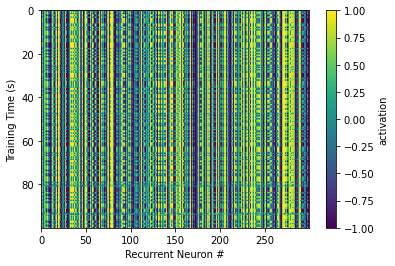

In [620]:
plt.imshow(r, aspect='auto')
# plt.imshow(r[:int(5/dt)], aspect='auto')
plt.xlabel("Recurrent Neuron #")
plt.ylabel("Training Time (s)")
ytick_locs = plt.yticks()[0][1:-1]
plt.yticks(ytick_locs, [int(val) for val in ytick_locs*dt])
plt.colorbar(label='activation')
plt.show()

In [621]:
def regress_output_weights(u, r, beta, squared_inds=None):
    D = u.shape[1]
    D_r = r.shape[1]
    P = np.zeros((D, D_r))
    
    P[0] = np.linalg.inv(r.T@r + beta*np.eye(D_r))@ r.T @ u[:, 0]
    P[1] = np.linalg.inv(r.T@r + beta*np.eye(D_r))@ r.T @ u[:, 1]
    
    r_tilde = r.copy()
    if squared_inds is not None:
         r_tilde[:, squared_inds] = r[:, squared_inds]**2
    P[2] = np.linalg.inv(r_tilde.T@r_tilde + beta*np.eye(D_r))@ r_tilde.T @ u[:, 2]
    
    return P

In [623]:
P = regress_output_weights(u[1:], r[1:], beta, squared_inds=squared_inds)

In [624]:
u_pred = np.array([W_out(r[t], P, squared_inds=squared_inds) for t in range(num_steps)])

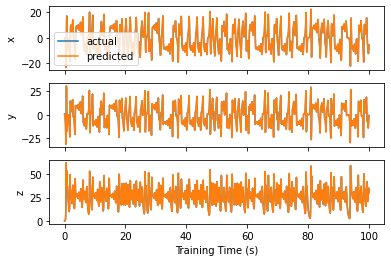

In [625]:
fig, axs = plt.subplots(3, 1, sharex=True)

for i, ax in enumerate(axs):
    ax.plot(np.arange(num_steps)*dt, u[:, i], label='actual')
    ax.plot(np.arange(num_steps)*dt, u_pred[:, i], label='predicted')
    ax.set_ylabel(['x', 'y', 'z'][i])

axs[0].legend()
plt.xlabel('Training Time (s)')
plt.show()

### Testing

In [632]:
T_test = 25
num_steps_test = int(T_test/dt)
r = np.zeros((num_steps_test, D_r))
v_out = np.zeros((num_steps_test, 3))

r[0] = r_init
v_out[0] = W_out(r[0], P, squared_inds=squared_inds)
r[1] = np.tanh(A@r[0] + W_in@u[0])
v_out[1] = W_out(r[1], P, squared_inds=squared_inds)

for t in range(1, num_steps_test-1):
    r[t + 1] = np.tanh(A@r[t] + W_in@v_out[t])
    v_out[t + 1] = W_out(r[t + 1], P, squared_inds=squared_inds)

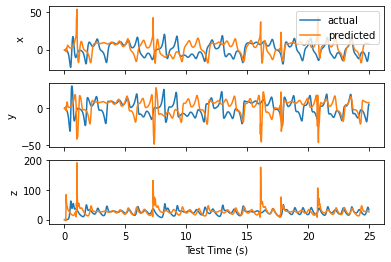

In [633]:
fig, axs = plt.subplots(3, 1, sharex=True)

for i, ax in enumerate(axs):
    ax.plot(np.arange(1, num_steps_test)*dt, u[1:num_steps_test, i], label='actual')
    ax.plot(np.arange(1, num_steps_test)*dt, v_out[1:, i], label='predicted')
    ax.set_ylabel(['x', 'y', 'z'][i])

axs[0].legend()
plt.xlabel('Test Time (s)')
plt.show()

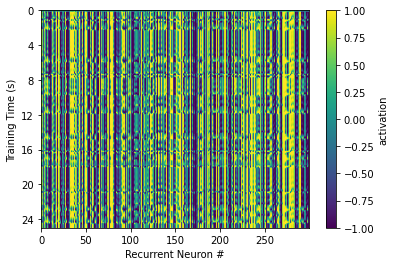

In [634]:
plt.imshow(r, aspect='auto')
plt.xlabel("Recurrent Neuron #")
plt.ylabel("Training Time (s)")
ytick_locs = plt.yticks()[0][1:-1]
plt.yticks(ytick_locs, [int(val) for val in ytick_locs*dt])
plt.colorbar(label='activation')
plt.show()